In [ ]:
import pandas as pd


df = pd.read_csv("Depresi(capstone).csv")


text_col = "full_text"  


depresi_keywords = [
    "bunuh diri", "capek", "putus asa",
    "takut", "cemas", "tidak berharga", "stres", "sedih",
    "sendiri", "menyerah", "gelisah", "kehilangan harapan, mati, melukai, lelah hidup"
]


def auto_label(text):
    if any(keyword in str(text).lower() for keyword in depresi_keywords):
        return "suicide"
    else:
        return "non-suicide"


df["label"] = df[text_col].apply(auto_label)


df.to_csv("Depresi_labeled_auto.csv", index=False)
print("✅ Dataset berhasil diberi label otomatis dan disimpan sebagai Depresi_labeled_auto.csv")


✅ Dataset berhasil diberi label otomatis dan disimpan sebagai Depresi_labeled_auto.csv


In [ ]:
import pandas as pd
import numpy as np
import re
import string
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk


df = pd.read_excel("suicide_capstone.xlsx",
                   engine="openpyxl",
                   index_col=False)

df.head()


,ID,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"Iâ€™m so lostHello, my name is Adam (16) and I...",suicide


In [3]:
df = df.loc[:, ~df.columns.str.contains("^Unnamed")]
print([col for col in df.columns if "Unnamed" in col])


[]


In [4]:
df.head()

,ID,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"Iâ€™m so lostHello, my name is Adam (16) and I...",suicide


In [5]:


print(df.head())
print(df.info())

print(df['class'].value_counts())

   ID                                               text        class
0   2  Ex Wife Threatening SuicideRecently I left my ...      suicide
1   3  Am I weird I don't get affected by compliments...  non-suicide
2   4  Finally 2020 is almost over... So I can never ...  non-suicide
3   8          i need helpjust help me im crying so hard      suicide
4   9  Iâ€™m so lostHello, my name is Adam (16) and I...      suicide
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28216 entries, 0 to 28215
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      28216 non-null  int64 
 1   text    28216 non-null  object
 2   class   28215 non-null  object
dtypes: int64(1), object(2)
memory usage: 661.4+ KB
None
class
non-suicide    14361
suicide        13854
Name: count, dtype: int64


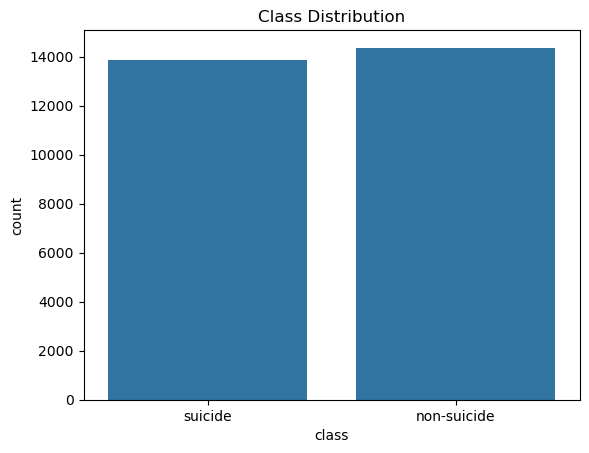

In [6]:
sns.countplot(x='class', data=df)
plt.title('Class Distribution')
plt.show()

In [7]:
print(df['class'].unique())


['suicide' 'non-suicide' nan]


In [8]:
df['class'] = df['class'].str.strip().str.lower()
df['label'] = df['class'].map({'suicide': 1, 'non-suicide': 0})


In [9]:
df = df.dropna(subset=['label'])


In [10]:
X = df['text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [11]:
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [12]:
model = LogisticRegression(max_iter=1000, class_weight='balanced')
model.fit(X_train_tfidf, y_train)

y_pred = model.predict(X_test_tfidf)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9246854510012404

Classification Report:
               precision    recall  f1-score   support

         0.0       0.91      0.94      0.93      2872
         1.0       0.94      0.91      0.92      2771

    accuracy                           0.92      5643
   macro avg       0.93      0.92      0.92      5643
weighted avg       0.92      0.92      0.92      5643



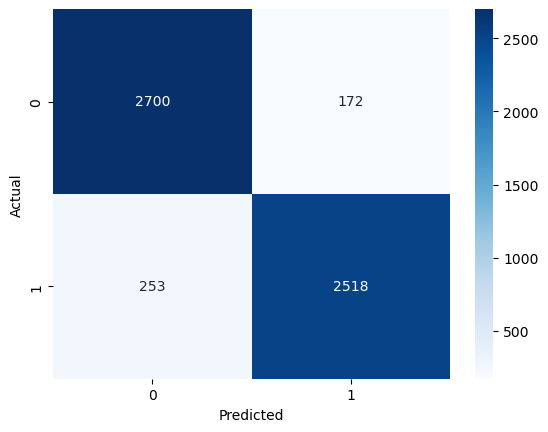

In [13]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
import os
import re
import random
import warnings
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW

import transformers
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup

import nltk
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support

warnings.filterwarnings('ignore')


random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


#NOTE:
try:
    df
except NameError:
    raise RuntimeError("DataFrame `df` not found. Please load your dataset into variable `df` before running this script.")


print("\nClass Distribution:")
print(df['class'].value_counts())
print(df['class'].value_counts(normalize=True) * 100)

print("\nMissing values in dataset:")
print(df.isnull().sum())


# NLTK resources

try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')


# Preprocessing

def preprocess_text(text):
    if isinstance(text, str):
        text = text.lower()
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        text = re.sub(r'@\w+', '', text)
        text = re.sub(r'[^\w\s]', '', text)
        text = re.sub(r'\d+', '', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text
    else:
        return ""

df['processed_text'] = df['text'].apply(preprocess_text)
df = df.dropna(subset=['processed_text'])
df = df[df['processed_text'] != ""] 

# Map class labels to numeric
df['label'] = df['class'].map({'suicide': 1, 'non-suicide': 0})


df['text_length'] = df['processed_text'].apply(len)
df['word_count'] = df['processed_text'].apply(lambda x: len(x.split()))


try:
    from nltk.sentiment.vader import SentimentIntensityAnalyzer
    nltk.download('vader_lexicon')
    sid = SentimentIntensityAnalyzer()
    df['sentiment_score'] = df['processed_text'].apply(lambda x: sid.polarity_scores(x)['compound'])
    df['sentiment_neg'] = df['processed_text'].apply(lambda x: sid.polarity_scores(x)['neg'])
    df['sentiment_pos'] = df['processed_text'].apply(lambda x: sid.polarity_scores(x)['pos'])
    print("Sentiment analysis features added.")
except Exception as e:
    print("VADER not available or failed, skipping sentiment analysis. Exception:", e)
    sid = None

suicide_indicators = [
    'kill', 'die', 'suicide', 'end', 'pain', 'life', 'anymore', 'want', 'hope',
    'help', 'death', 'dead', 'hate', 'tired', 'pills', 'hurt', 'alone', 'sad',
    'depression', 'anxiety', 'lost', 'cut', 'empty', 'worthless'
]

for word in suicide_indicators:
    df[f'has_{word}'] = df['processed_text'].apply(lambda x: 1 if word in x.split() else 0)

first_person_pronouns = ['i', 'me', 'my', 'mine', 'myself']
df['first_person_count'] = df['processed_text'].apply(
    lambda x: sum(1 for word in x.split() if word in first_person_pronouns)
)

print("\nSample of dataset with engineered features:")
print(df.head())

# Visualize
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.boxplot(x='class', y='text_length', data=df)
plt.title('Text Length by Class')
plt.subplot(1, 2, 2)
sns.boxplot(x='class', y='word_count', data=df)
plt.title('Word Count by Class')
plt.tight_layout()
plt.savefig('feature_distributions.png')
plt.close()


# Prepare data for BERT

X_train, X_test, y_train, y_test = train_test_split(
    df['processed_text'],
    df['label'],
    test_size=0.2,
    random_state=42,
    stratify=df['label']
)

# Load tokenizer & model name
MODEL_NAME = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
max_length = 128

class SuicideDetectionDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts.reset_index(drop=True)
        self.labels = labels.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts.iloc[idx])
        label = int(self.labels.iloc[idx])

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

train_dataset = SuicideDetectionDataset(X_train, y_train, tokenizer, max_length)
test_dataset = SuicideDetectionDataset(X_test, y_test, tokenizer, max_length)


batch_size = 32


if torch.cuda.is_available() and os.name != 'nt':
    dl_num_workers = 2
else:
    dl_num_workers = 0

dl_pin_memory = True if torch.cuda.is_available() else False


persistent_workers_flag = (dl_num_workers > 0)

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=dl_num_workers,
    pin_memory=dl_pin_memory,
    persistent_workers=persistent_workers_flag
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=dl_num_workers,
    pin_memory=dl_pin_memory,
    persistent_workers=persistent_workers_flag
)

print(f"\nDataLoader setup -> batch_size: {batch_size}, num_workers: {dl_num_workers}, pin_memory: {dl_pin_memory}")


try:
    sample_batch = next(iter(train_loader))
    print("Sample batch shapes ->",
          sample_batch['input_ids'].shape,
          sample_batch['attention_mask'].shape,
          sample_batch['label'].shape)
except Exception as e:
    print("Warning: Could not get sample batch from train_loader. Error:", e)


# Initialize model

model = BertForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False
)
model = model.to(device)


# Optimizer & Scheduler

optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
epochs = 1
total_steps = len(train_loader) * epochs if len(train_loader) > 0 else 1

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)


# Training & Evaluation functions

def train_model(model, train_loader, optimizer, scheduler, device, debug_every=100):
    model.train()
    total_loss = 0.0

    
    progress_bar = tqdm(enumerate(train_loader), desc="Training", total=len(train_loader), leave=True)

    for batch_idx, batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        if scheduler is not None:
            try:
                scheduler.step()
            except Exception:
                pass

        progress_bar.set_postfix({'loss': f"{loss.item():.4f}", 'batch': f"{batch_idx+1}/{len(train_loader)}"})
        if (batch_idx + 1) % debug_every == 0:
            print(f"[DEBUG] batch {batch_idx+1}/{len(train_loader)} - loss: {loss.item():.4f}")

    avg_loss = total_loss / len(train_loader) if len(train_loader) > 0 else total_loss
    return avg_loss

def evaluate_model(model, test_loader, device):
    model.eval()
    predictions = []
    actual_labels = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, preds = torch.max(outputs.logits, dim=1)
            predictions.extend(preds.cpu().tolist())
            actual_labels.extend(labels.cpu().tolist())

    return predictions, actual_labels


if torch.cuda.is_available():
    torch.cuda.empty_cache()

training_losses = []
for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs} — device: {device}, num_workers: {dl_num_workers}, pin_memory: {dl_pin_memory}")

    avg_train_loss = train_model(model, train_loader, optimizer, scheduler, device, debug_every=100)
    training_losses.append(avg_train_loss)

    print(f"Average training loss: {avg_train_loss:.4f}")

    # Evaluate on last epoch
    if epoch == epochs - 1:
        print("\nEvaluating model...")
        predictions, actual_labels = evaluate_model(model, test_loader, device)

        accuracy = accuracy_score(actual_labels, predictions)
        precision, recall, f1, _ = precision_recall_fscore_support(
            actual_labels, predictions, average='weighted'
        )

        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")

        print("\nClassification Report:")
        print(classification_report(actual_labels, predictions, target_names=['Non-suicidal', 'Suicidal']))

        cm = confusion_matrix(actual_labels, predictions)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Non-suicidal', 'Suicidal'],
                    yticklabels=['Non-suicidal', 'Suicidal'])
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title('Confusion Matrix')
        plt.tight_layout()
        plt.savefig('confusion_matrix.png')
        plt.close()

# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs+1), training_losses, marker='o')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.grid(True)
plt.savefig('training_loss.png')
plt.close()


# Prediction utilities (unchanged logic)

def predict_suicide_risk(text, model, tokenizer, device, max_length=128):
    processed_text = preprocess_text(text)
    encoding = tokenizer.encode_plus(
        processed_text,
        add_special_tokens=True,
        max_length=max_length,
        return_token_type_ids=False,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

    probs = torch.nn.functional.softmax(outputs.logits, dim=1)
    _, prediction = torch.max(probs, dim=1)

    return {
        'prediction': 'Suicidal' if prediction.item() == 1 else 'Non-suicidal',
        'confidence': probs[0][prediction.item()].item(),
        'suicidal_prob': probs[0][1].item(),
        'non_suicidal_prob': probs[0][0].item()
    }

def analyze_predictions(text, prediction_result):
    suicide_indicators_present = []
    for word in suicide_indicators:
        if word in text.lower().split():
            suicide_indicators_present.append(word)

    first_person_count = sum(1 for word in text.lower().split() if word in first_person_pronouns)
    text_length = len(text)
    word_count = len(text.split())

    sentiment_score = None
    try:
        if sid is not None:
            sentiment_score = sid.polarity_scores(text)['compound']
    except:
        sentiment_score = None

    print("\nPrediction Analysis:")
    print(f"- Prediction: {prediction_result['prediction']} with {prediction_result['confidence']:.2%} confidence")
    print(f"- Text length: {text_length} characters, {word_count} words")
    if sentiment_score is not None:
        label = 'Positive' if sentiment_score > 0 else 'Negative' if sentiment_score < 0 else 'Neutral'
        print(f"- Sentiment score: {sentiment_score:.2f} ({label})")
    print(f"- First-person pronouns used: {first_person_count}")

    if suicide_indicators_present:
        print(f"- Potential concerning words detected: {', '.join(suicide_indicators_present)}")
    else:
        print("- No specific concerning words detected from our indicator list")

    return {
        'indicators': suicide_indicators_present,
        'first_person_count': first_person_count,
        'text_length': text_length,
        'word_count': word_count,
        'sentiment': sentiment_score
    }


print("\nExample prediction:")
example_text = "I don't know if I can keep going anymore. Everything feels so hopeless."
result = predict_suicide_risk(example_text, model, tokenizer, device)
print(f"Input text: {example_text}")
print(f"Prediction: {result['prediction']}")
print(f"Confidence: {result['confidence']:.4f}")
print(f"Probability of suicidal: {result['suicidal_prob']:.4f}")
print(f"Probability of non-suicidal: {result['non_suicidal_prob']:.4f}")


output_dir = './model_save/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
print(f"\nModel saved to {output_dir}")


print("\nDetailed prediction analysis:")
example_text2 = "I'm so tired of everything. I don't think I want to be alive anymore."
result2 = predict_suicide_risk(example_text2, model, tokenizer, device)
analysis = analyze_predictions(example_text2, result2)


def suicide_risk_assessment_system(text, model, tokenizer, device):
    prediction = predict_suicide_risk(text, model, tokenizer, device)
    analysis = analyze_predictions(text, prediction)

    risk_level = "Low"
    if prediction['suicidal_prob'] > 0.8:
        risk_level = "High"
    elif prediction['suicidal_prob'] > 0.5:
        risk_level = "Medium"

    response = "The system has completed its assessment. "
    if risk_level == "High":
        response += "This conversation shows significant indicators of suicide risk. Immediate professional intervention is recommended."
    elif risk_level == "Medium":
        response += "This conversation shows some concerning patterns that may indicate suicide risk. Further assessment by a mental health professional is recommended."
    else:
        response += "This conversation does not show strong indicators of immediate suicide risk. However, regular monitoring is still advised as risk factors can change."

    return {
        'text': text,
        'prediction': prediction,
        'analysis': analysis,
        'risk_level': risk_level,
        'response': response
    }

print("\nComplete Suicide Risk Assessment System Example:")
test_conversations = [
    "I had a rough day today but I'll be fine after some rest.",
    "I can't take this pain anymore. I just want it all to end. No one would miss me anyway.",
    "I've been feeling down lately and finding it hard to see the point in things."
]

for i, conversation in enumerate(test_conversations):
    print(f"\nConversation {i+1}: '{conversation}'")
    result = suicide_risk_assessment_system(conversation, model, tokenizer, device)
    print(f"Risk Level: {result['risk_level']}")
    print(f"System Response: {result['response']}")

print("\nNOTE: This model is intended as a support tool for trained professionals, not as an autonomous decision-maker.")
print("Always consult with mental health professionals for proper assessment and intervention in potential suicide risk cases.")


Using device: cpu

Class Distribution:
class
non-suicide    14361
suicide        13854
Name: count, dtype: int64
class
non-suicide    50.898458
suicide        49.101542
Name: proportion, dtype: float64

Missing values in dataset:
ID       0
text     0
class    0
label    0
dtype: int64


[nltk_data] Downloading package vader_lexicon to C:\Users\MUHAMMAD
[nltk_data]     ILHAM\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Sentiment analysis features added.

Sample of dataset with engineered features:
   ID                                               text        class  label  \
0   2  Ex Wife Threatening SuicideRecently I left my ...      suicide      1   
1   3  Am I weird I don't get affected by compliments...  non-suicide      0   
2   4  Finally 2020 is almost over... So I can never ...  non-suicide      0   
3   8          i need helpjust help me im crying so hard      suicide      1   
4   9  Iâ€™m so lostHello, my name is Adam (16) and I...      suicide      1   

                                      processed_text  text_length  word_count  \
0  ex wife threatening suiciderecently i left my ...          703         143   
1  am i weird i dont get affected by compliments ...          136          27   
2  finally is almost over so i can never hear has...          112          24   
3          i need helpjust help me im crying so hard           41           9   
4  iâm so losthello my name is ada

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/1 — device: cpu, num_workers: 0, pin_memory: False


Training:  14%|█▍        | 100/706 [48:15<4:49:12, 28.63s/it, loss=0.2814, batch=100/706]

[DEBUG] batch 100/706 - loss: 0.2814


Training:  28%|██▊       | 200/706 [1:23:19<3:07:55, 22.28s/it, loss=0.0507, batch=200/706]

[DEBUG] batch 200/706 - loss: 0.0507


Training:  42%|████▏     | 300/706 [1:54:31<1:56:28, 17.21s/it, loss=0.0269, batch=300/706]

[DEBUG] batch 300/706 - loss: 0.0269


Training:  57%|█████▋    | 400/706 [2:53:12<3:16:50, 38.60s/it, loss=0.0219, batch=400/706]

[DEBUG] batch 400/706 - loss: 0.0219


Training:  71%|███████   | 500/706 [4:02:03<2:06:16, 36.78s/it, loss=0.1271, batch=500/706]

[DEBUG] batch 500/706 - loss: 0.1271


Training:  85%|████████▍ | 600/706 [4:54:20<58:45, 33.26s/it, loss=0.0284, batch=600/706]  

[DEBUG] batch 600/706 - loss: 0.0284


Training:  99%|█████████▉| 700/706 [5:45:05<02:50, 28.45s/it, loss=0.1694, batch=700/706]  

[DEBUG] batch 700/706 - loss: 0.1694


Training: 100%|██████████| 706/706 [5:47:44<00:00, 29.55s/it, loss=0.0037, batch=706/706]


Average training loss: 0.1347

Evaluating model...


Evaluating: 100%|██████████| 177/177 [09:19<00:00,  3.16s/it]


Accuracy: 0.9686
Precision: 0.9686
Recall: 0.9686
F1 Score: 0.9686

Classification Report:
              precision    recall  f1-score   support

Non-suicidal       0.97      0.97      0.97      2872
    Suicidal       0.97      0.97      0.97      2771

    accuracy                           0.97      5643
   macro avg       0.97      0.97      0.97      5643
weighted avg       0.97      0.97      0.97      5643


Example prediction:
Input text: I don't know if I can keep going anymore. Everything feels so hopeless.
Prediction: Suicidal
Confidence: 0.6593
Probability of suicidal: 0.6593
Probability of non-suicidal: 0.3407

Model saved to ./model_save/

Detailed prediction analysis:

Prediction Analysis:
- Prediction: Non-suicidal with 51.77% confidence
- Text length: 69 characters, 14 words
- Sentiment score: -0.21 (Negative)
- First-person pronouns used: 2
- Potential concerning words detected: want, tired

Complete Suicide Risk Assessment System Example:

Conversation 1: 'I had a ro

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


tokenizer = BertTokenizer.from_pretrained("./model_save/")
model = BertForSequenceClassification.from_pretrained("./model_save/").to(device)


In [6]:
def predict(text, model, tokenizer, device):
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=128
    ).to(device)

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    probs = torch.softmax(logits, dim=1).cpu().numpy()[0]
    predicted_class = int(probs.argmax())

    return predicted_class, probs


In [ ]:
labels = ["Non-Suicidal", "Suicidal"] 

text = "I want to end it all right now."
pred_class, probs = predict(text, model, tokenizer, device)

print("Text:", text)
print("Prediction:", labels[pred_class])
print("Probabilities:", probs)


Text: I want to end it all right now.
Prediction: Non-Suicidal
Probabilities: [0.5530432  0.44695684]
